# Distracted Driving Prediction
## Deep Learning with python, keras & tensorflow
### Sean O'Malley

The goal of this analysis is to identify the various types of distracted driving scenarios simply using images. We will accomplish this by using deep learning in python with the keras and a tensorflow backend. 

As a contextual reference, deep learning is a subset of machine learning that allows algorithms to train itself in order to perform tasks like image and speech recognition. Deep learning accomplishes this by revealing immense amounts of data to multi-layered neural networks.

This document will walk you through the entire process of: 
* Ingest a list of images
* Transform them into something that can be understood by a computer
* Split into test and training groups
* Prepare data to fit into a deep learning model


* Sequential API deep learning model
* Functional API deep learning model
* Functional API deep learning model
    + with inception module architecture
* Functional API deep learning model
    + with inception module architecture
    + using BatchNormalization to combat overfitting

Providing commentary, summary statistics and visualization along the way, we will determine the most successful model to move forward with in identifying distracted driving via images. 

We will conclude with a summary of the strengths, weaknesses and opportunities for improvement in the models to help fully understand the data, the models and the ultimate application of the analysis.


__Package Import__

In [11]:
# Basic Packages
import time
import numpy as np
import pandas as pd
import os, sys

# Deep Learning Packages
from keras.models import Sequential, Model, model_from_json
from keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical, np_utils

from keras import backend as K
from keras.optimizers import Adam, RMSprop
import h5py

# Image Import & View Packages
import glob
import matplotlib.pyplot as plt
from PIL import Image


__Exploratory Data Analysis__

Ingest and view summaries of csv's to help us gain an understanding of the data we have. Looking at the data below, you'll see that we have 10 classes of images, living in separate photos. The photos are already categorized in their predefined classes by folders.

In [248]:
driver_imgs_list = pd.read_csv('driver_imgs_list.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [249]:
driver_imgs_list.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [250]:
sample_submission.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


__Image Characteristics__

We see that the images are jpegs, 640x480 pixels and in full RGB color.

In [251]:
print(imagetest.format, imagetest.size, imagetest.mode)

JPEG (320, 240) RGB


__Ingest The Test Data__

This is the final test data our model will attempt to classify. We do now have a access to the actual classification values of this test data, so to test / train our model we will divide the previously classified data into test and train data then run the model we built against this unknown distracted driver data.

In [252]:
X_test = []
#y = []
path = os.path.join('imgs', 'test','*.jpg')
img_list = glob.glob(path)
print(len(img_list))
print(len(img_list[:25000]))

for file in img_list[:25000]:
    img = Image.open(file).convert('L')
    height, width = img.size
    # thumbnail is a in-place operation
    img = img.resize(( int(height/10), int(width/10) ), Image.ANTIALIAS) #, Image.ANTIALIAS
    pix = np.array(img.getdata()).reshape(img.size[0],img.size[1],1)
    X_test.append(pix)
    #y.append(j)
        
print("Number of test images: %s" % len(X_test))

X_test = np.array(X_test) 
print(X_test.shape)

79726
25000
Number of test images: 25000
(25000, 64, 48, 1)


__Manipulate and Transform Image Data__

The below outer for loop ingests each image from their respective folders while maintaining the classification of the image.

The nested for loop takes each image, converts it to black and white, reduces the image by a magnitued of 10, puts the image pixel values into a numpy array, appending values to the respective X (train) and y (test) lists.

In [253]:
X = []
y = []
for j in range(10):
    print('Load folder c{}'.format(j))
    path = os.path.join('imgs', 'train', 'c' + str(j), '*.jpg')
    img_list = glob.glob(path)
    for file in img_list:
        img = Image.open(file).convert('L')
        height, width = img.size
       # thumbnail is a in-place operation
        img = img.resize(( int(height/10), int(width/10) ), Image.ANTIALIAS) #, Image.ANTIALIAS
        pix = np.array(img.getdata()).reshape(img.size[0],img.size[1],1)
        X.append(pix)
        y.append(j)
        
    print("Number of train images: %s" % len(X))

Load folder c0
Number of train images: 2489
Load folder c1
Number of train images: 4756
Load folder c2
Number of train images: 7073
Load folder c3
Number of train images: 9419
Load folder c4
Number of train images: 11745
Load folder c5
Number of train images: 14057
Load folder c6
Number of train images: 16382
Load folder c7
Number of train images: 18384
Load folder c8
Number of train images: 20295
Load folder c9
Number of train images: 22424


__Encode X and y__

Because we are attempting to classify the images, we need to change y to categorical data for keras to understand what it is trying to classify. We also need to alter X to be a numpy array because the loop outputs a list.

In [254]:
Y = to_categorical(y)
print(Y.shape)

(22424, 10)


In [255]:
X = np.array(X) 
print(X.shape)

(22424, 64, 48, 1)


__Test / Train Shuffle and Split__

We then take the X and y lists and turn them into float value numpy arrays. After that, we shuffle the order of the data image by index and then split into test and train groups.

Prep Shuffle on index

In [256]:
ind = np.array(list(range(22424)))
seed = 500
np.random.seed(seed)
np.random.shuffle(ind)
print(ind[:10])

[ 9994  4965  5208  2681 15911  5972   547 12219 18670 16198]


Apply shuffle to test and train

In [257]:
Xs = X[ind]
Ys = Y[ind]

__Determine validity of split__

Comparing X with Xs we can see that we have properly shuffled our test / train split.

In [258]:
print("shape of Ys:" + str(Ys.shape))
print("shape of Xs:" + str(Xs.shape))

shape of Ys:(22424, 10)
shape of Xs:(22424, 64, 48, 1)


Y looks properly shuffled

In [259]:
print(Y[0], Ys[0])

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.] [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]


X also looks like things have been shuffled correctly

In [260]:
X[0].sum() - Xs[0].sum()

35584

__Normalization Process__

In [261]:
print(Xs.dtype)
print(Xs.max()) 

int64
255


In [262]:
Xs = (Xs-(Xs.max()/2))/Xs.max()

In [263]:
print(Xs.dtype)
print(Xs.mean())
print(Xs.max())
print(Xs.min())

float64
-0.142253596592
0.5
-0.5


Alter datatype to float to create more disk space

In [264]:
print("original disk space with " + str(Xs.dtype) + " is " + str(Xs.nbytes/10**9)) 
Xs = Xs.astype('float32')
print("new disk space: "  + str(Xs.dtype) + " is " + str(Xs.nbytes/10**9)) 

original disk space with float64 is 0.551092224
new disk space: float32 is 0.275546112


__Save to hdf5 file type__

Due to size and hierarchical data structure, which lets you assign tags/groups or subgroups to your data. I will also re-ingest the data in a way that automatically creates the test and train groups for our model to learn on. 

_Training Data_

In [297]:
with h5py.File('traindata.hdf5','w') as f:
    f.create_dataset('X', data=Xs)
    f.create_dataset('Y', data=Ys)

In [3]:
with h5py.File('traindata.hdf5','r') as f:
    X_train = f['X'][7001:] #the [()] means load all data
    X_test = f['X'][:7000] #read first 1000 samples
    
    Y_train = f['Y'][7001:] #the [()] means load all data
    Y_test = f['Y'][:7000] #read first 1000 samples

_Final Testing Data_

In [299]:
with h5py.File('testdata.hdf5','w') as f:
    f.create_dataset('X', data=X_test)

In [4]:
with h5py.File('testdata.hdf5','r') as f:
    X_Final_Test = f['X'][()] #the [()] means load all data

__Visualize Shape before modeling__

We want to see the structure of the data we are using to teach our model.

In [5]:
print("X Test")
print(X_test.shape)

print("X Train")
print(X_train.shape)

print("Y Test:")
print(Y_test.shape)

print("Y Train:")
print(Y_train.shape)

X Test
(7000, 64, 48, 1)
X Train
(15423, 64, 48, 1)
Y Test:
(7000, 10)
Y Train:
(15423, 10)


__Basic Sequential Model:__ _Build_

The <a href="https://keras.io/models/sequential/">Sequential API</a> allows you to create models layer by layer after initiating the _Sequential()_ function in a model. The operations are limited in that Sequential does not allow you to create models that share layers or have multiple inputs or outputs. However this simple model can prove incredibly effective, permitting you to summarize, fit, evaluate and make predictions.

We first want to prep the inputs to the model. Pulling out the number of classes and ensuring that y is categorical

In [6]:
num_pixels = X_train.shape[1] * X_train.shape[2]
num_classes = Y_test.shape[1]

In [7]:
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

Now, lets build the most basic sequential model and see how it performs

In [8]:
# Create Model as Function
def simple_sequential_model():
    model = Sequential()
    model.add(Dense(num_pixels, input_dim=num_pixels, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    return model

Train on 15423 samples, validate on 7000 samples
Epoch 1/20
 - 32s - loss: 2.1491 - acc: 0.4655 - val_loss: 1.1858 - val_acc: 0.6167
Epoch 2/20
 - 30s - loss: 0.6972 - acc: 0.8271 - val_loss: 0.4695 - val_acc: 0.9006
Epoch 3/20
 - 31s - loss: 0.3253 - acc: 0.9348 - val_loss: 0.2924 - val_acc: 0.9284
Epoch 4/20
 - 32s - loss: 0.1872 - acc: 0.9651 - val_loss: 0.1970 - val_acc: 0.9539
Epoch 5/20
 - 32s - loss: 0.1202 - acc: 0.9790 - val_loss: 0.1764 - val_acc: 0.9541
Epoch 6/20
 - 30s - loss: 0.0934 - acc: 0.9824 - val_loss: 0.1207 - val_acc: 0.9740
Epoch 7/20
 - 28s - loss: 0.0717 - acc: 0.9864 - val_loss: 0.1052 - val_acc: 0.9739
Epoch 8/20
 - 27s - loss: 0.0515 - acc: 0.9907 - val_loss: 0.0855 - val_acc: 0.9781
Epoch 9/20
 - 28s - loss: 0.0445 - acc: 0.9916 - val_loss: 0.0768 - val_acc: 0.9813
Epoch 10/20
 - 27s - loss: 0.0353 - acc: 0.9940 - val_loss: 0.0604 - val_acc: 0.9854
Epoch 11/20
 - 27s - loss: 0.0234 - acc: 0.9970 - val_loss: 0.0649 - val_acc: 0.9817
Epoch 12/20
 - 27s - loss

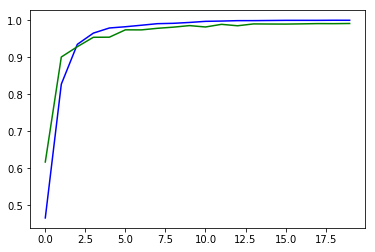

In [18]:
# Build Model
model = simple_sequential_model()

# Fit Model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=200, verbose=2)

# Evaluate Model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

# Visualize Model
plt.plot(history.history['acc'],'b') #train acc
plt.plot(history.history['val_acc'],'g') #val acc

__Basic Sequential Model:__  _Evaluate_

This appears to be an extremely accurate model, however this could very well be me screwing something up, because its an incredibly simple model and in my mind should not be able to predict this well.

__Save Model__

We want so save this specific model off as a json, and weights to hdf5 for reusability purposes

In [19]:
# serialize model to JSON
model_json = model.to_json()
with open("simple_sequential_model.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
model.save_weights("simple_sequential_model.h5")
print("Saved model to disk")

Saved model to disk


__Read in Model__

In [20]:
# load json and create model
json_file = open('simple_sequential_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("simple_sequential_model.h5")
print("Loaded model from disk")

Loaded model from disk


__Basic Sequential Model:__ _Predict Final Test Data_

In [21]:
# evaluate loaded model on test data
#loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))